# Introduction

In this notebook we load and analyze two velocity datasets derived from DART impact simulations on the Didymos–Dimorphos binary system. Each dataset contains 1000 velocity samples for a single simulated particle: one dataset corresponds to a particle that escapes the binary system after the impact, while the other corresponds to a particle that remains inside the system (due to impact on Didymos or Dimorphos, or by being placed on an unstable orbit). The raw files are located in the `data/raw/` folder.

Objective
- Identify whether there are clear turning points or threshold regions in the velocity distributions that separate escape from retention.
- Build machine learning models capable of mapping the probability of escape as a function of velocity features and to estimate critical velocity ranges where the transition occurs.

Analysis workflow
- Data loading and validation: read CSV files, check for missing or inconsistent values, and verify units.
- Exploratory data analysis (EDA): histograms, kernel density estimates, scatter plots, and comparison of distributions between the two groups.
- Feature engineering: compute scalar speed, velocity components, and any transformations that improve separability for modeling.
- Machine learning modeling: train interpretable classifiers (e.g., logistic regression) and non-linear models (e.g., Random Forest) to predict escape vs retention.
- Turning point detection: analyze model decision functions and probability curves, and compute derivatives of the escape probability with respect to velocity to estimate threshold regions.
- Validation and interpretation: use cross-validation and metrics (accuracy, ROC-AUC, precision/recall), and apply feature-importance methods (e.g., permutation importance or SHAP) to interpret results.

Practical notes
- Subsequent cells provide code to load the files from `data/raw/`, produce EDA figures, train models with cross-validation, and save key outputs to `results/`.
- Save important figures, models, and tables to the `results/` folder for later reference and inclusion in the thesis.

In [1]:
import numpy as np
import pandas as pd

#Load data from raw folder
path = "../data/raw"
def load_datasets():
    df1 = pd.read_csv(f"{path}/2nd_simulation_escaped.csv")
    df2 = pd.read_csv(f"{path}/2nd_simulation_survived.csv")
    return df1, df2

#Check for missing or inconsistent data
def check_data_quality(df):
    print("Missing values per column:")
    print(df.isnull().sum())
    print("\nData types:")
    print(df.dtypes)

#Use the function to load datasets
df_escaped, df_survived = load_datasets()
#check_data_quality(df_escaped)
#check_data_quality(df_survived)


#### Exploratory Data Analysis

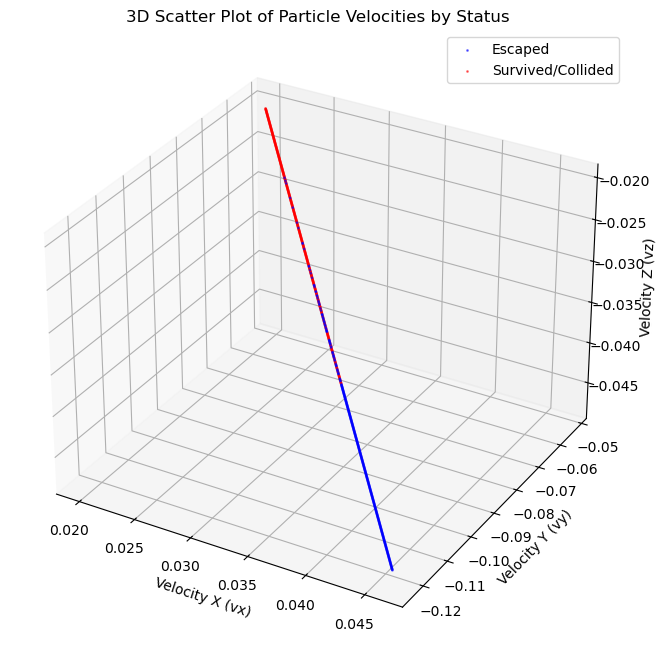

In [8]:
#Plot for exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns

def plot_3d_velocity_status(df):
    #Select columns for 3D plot
    x = df['vx']
    y = df['vy']
    z = df['vz']
    status = df['st'] 

    #Define color mask based on status
    #st=1 escaped in blue, st!=1 survived/collided in red
    is_escaped = (status == 1)

    #Create 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    #Scatter plot for escaped particles, s = size of points, alpha = transparency
    ax.scatter(x[is_escaped], y[is_escaped], z[is_escaped], c='blue', label='Escaped', alpha=0.5, s=1)
    #Scatter plot for survived/collided particles
    ax.scatter(x[~is_escaped], y[~is_escaped], z[~is_escaped], c='red', label='Survived/Collided', alpha=0.5, s=1)

    #Set labels and title
    ax.set_xlabel('Velocity X (vx)')
    ax.set_ylabel('Velocity Y (vy)')
    ax.set_zlabel('Velocity Z (vz)')
    ax.set_title('3D Scatter Plot of Particle Velocities by Status')
    ax.legend()
    plt.show()

#Use the function to plot data
plot_3d_velocity_status(df_escaped)


It is possible to observe that particles with higher velocity values tend to escape, while those with lower velocity values are more likely to survive or collide. The separation is not perfectly clear-cut, indicating that other factors may also influence the fate of the particles. It is also possible to plot the velocity magnitude (speed) against the status (since the velocity is monodirectional, the plot will look similar to the 3d plot) to condensate the information.

#### 1D Graphic Analysis
The goal is to visualize how the status st of the particle changes with respect to the velocity module (speed), keeping separated the two datasets in order to see if there are differences in the distributions.

In [12]:
#Compute the magnitude of velocity (speed)
def compute_speed(df):
    df['speed'] = np.sqrt(df['vx']**2 + df['vy']**2 + df['vz']**2)
    return df

df_escaped['v_mag'] = compute_speed(df_escaped)
df_survived['v_mag'] = compute_speed(df_survived)

#Plot (2 different datasets) speed vs status
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

#Helper function to plot speed vs status
def plot_particle(ax, df, title):
    #Escape particles in blue (st=1)
    escaped = df[df['st'] == 1]
    ax.scatter(escaped['v_mag'], escaped['st'], c='blue', label='Escaped', alpha=0.5, s=1)
    #Non-escaped particles in red (st!=1)
    non_escaped = df[df['st'] != 1]
    ax.scatter(non_escaped['v_mag'], non_escaped['st'], c='red', label='Survived/Collided', alpha=0.5, s=1)
    
    #Set labels and title
    ax.set_xlabel('Speed (m/s)')
    ax.set_ylabel('Status (st)')
    ax.set_title(title)
    ax.legend()

#Plot for escaped dataset
plot_particle(ax1, df_escaped, 'Speed vs Status (Escaped Dataset)')
#Plot for survived dataset 
plot_particle(ax2, df_survived, 'Speed vs Status (Survived Dataset)')   

plt.tight_layout()
plt.show()

ValueError: Cannot set a DataFrame with multiple columns to the single column v_mag